# CS211 Final Project

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0


def above_threshold(query_results, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)
    for idx, q in enumerate(query_results):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q + nu_i >= T_hat:
            return idx
    return None


heights = pd.read_csv('https://raw.githubusercontent.com/alexdowns0/CS211_Final_Project/main/Heights.csv')
len(heights)

4500

In [2]:
## Cache the sorted ages, because we will use them a lot.
height_lower = 0
height_upper = 100
sorted_heights = heights['Height'].clip(lower=height_lower, upper=height_upper).sort_values()

def min_height():
    clipped_heights = heights['Height'].clip(lower=0, upper=100)
    return clipped_heights.min()

def percentile(q):
    return heights["Height"].quantile(q)


print('Actual minimum height:', min_height(), 'inches')

print(percentile(.71))


Actual minimum height: 65.0 inches
80.0


In [3]:
assert min_height() == 65.0
assert min_height() == percentile(0)

In [4]:
# more chunks means more noise to signal ratio

bs = list(range(60, 96, 3))
def f(chunk, q):
    return (chunk.quantile(q))

def saa_percentile_height(k, epsilon, q):
    df = heights['Height']
    # Calculate the number of rows in each chunk
    chunk_size = int(np.ceil(df.shape[0] / k))
    # Step 1: split `df` into chunks
    xs = [df[i:i+chunk_size] for i in range(0,df.shape[0],chunk_size)]
    # Step 2: run f on each x_i and clip its output
    answers = pd.Series([f(x_i, q) for x_i in xs])
    
    
    def upper(answers, b_lower, epsilon):
        query_results = [(answers.clip(lower=b_lower, upper=b)).sum() -
        answers.clip(lower=b_lower, upper=b+1).sum() for b in bs]
        idx = above_threshold(query_results, 0, epsilon)
        if idx == None:
            return bs[-1]
        else:
            return bs[idx]
    l = 60
    u = upper(answers, l, 3 * epsilon/4)
    #print("Upper Clipping parameter: " , u)
    clipped_answers = np.clip(answers, l, u) 
    # Step 3: take the noisy mean of the clipped answers
    noisy_sum = laplace_mech(np.sum(clipped_answers), u-1, epsilon/4)
    noisy_mean = noisy_sum / k
    return noisy_mean


p = .5
epsilon = 1
print(saa_percentile_height(10, epsilon, p))
print(percentile(p))



96.03803758633313
78.0


Median error for min heights:  3.5963298980602385
Mean error for min heights:  3.6540144465008164 

Median error for max heights:  6.0265196430314525
Mean error for max heights:  6.578548077779294 

Median error for med heights:  0.8437831674372048
Mean error for med heights:  1.2710404286805224 



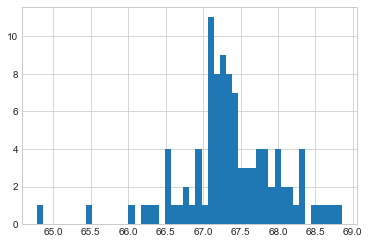

In [5]:
# TEST CASES
true_min = heights['Height'].min()
true_max = heights['Height'].max()
true_med = percentile(.5)

# Minimum trials
min_trials = [saa_percentile_height(700, 1.0,0) for _ in range(100)]
min_errors = [pct_error(true_min, t) for t in min_trials]
print('Median error for min heights: ', np.median(min_errors))
print('Mean error for min heights: ', np.mean(min_errors),"\n")

#Max Trials
max_trials = [saa_percentile_height(100, 1.0,1.0) for _ in range(100)]
max_errors = [pct_error(true_max, t) for t in max_trials]
print('Median error for max heights: ', np.median(max_errors))
print('Mean error for max heights: ', np.mean(max_errors),"\n")

#Med trials
med_trials = [saa_percentile_height(300, 1.0,0.5) for _ in range(100)]
med_errors = [pct_error(true_med, t) for t in med_trials]
print('Median error for med heights: ', np.median(med_errors))
print('Mean error for med heights: ', np.mean(med_errors),"\n")




# include histogram for the number of trials
plt.hist(min_trials, bins =50);

assert np.mean(min_errors) > 0
assert np.mean(min_errors) < 11
assert np.median(min_errors) > 0
assert np.median(min_errors) < 100



In [6]:
# TEST CASES
true_min = heights['Height'].min()
true_max = heights['Height'].max()
true_med = percentile(.5)

# Minimum trials
min_trials = [saa_percentile_height(100, 1.0,0) for _ in range(100)]
min_errors = [pct_error(true_min, t) for t in min_trials]
print('Median error for min heights: ', np.median(min_errors))
print('Mean error for min heights: ', np.mean(min_errors),"\n")

#Max Trials
max_trials = [saa_percentile_height(100, 1.0,1.0) for _ in range(100)]
max_errors = [pct_error(true_max, t) for t in max_trials]
print('Median error for max heights: ', np.median(max_errors))
print('Mean error for max heights: ', np.mean(max_errors),"\n")

#Med trials
med_trials = [saa_percentile_height(100, 1.0,0.5) for _ in range(100)]
med_errors = [pct_error(true_med, t) for t in med_trials]
print('Median error for med heights: ', np.median(med_errors))
print('Mean error for med heights: ', np.mean(med_errors),"\n")




Median error for min heights:  8.90682148890889
Mean error for min heights:  9.933446270156821 

Median error for max heights:  6.460032416604971
Mean error for max heights:  7.296526643760313 

Median error for med heights:  2.0805663387634175
Mean error for med heights:  3.5178569521710505 

